# Homework 4

## ASTR 5900, Fall 2020

### KMeans and PCA

# Problem 1

### Part A

Load the Old Faithful data (remember this?) from http://www.stat.cmu.edu/~larry/all-of-statistics/=data/faithful.dat.  

A standard procedure in problems with multi-dimensional data is to standardize the data, or give each dimension the same scaling.  It is common to make every parameter distributed around 0 with a standard variance.  That is, find a new data set with parameters $y_{i}^{(j)}$ where:

$$ y_{i}^{(j)} = \frac{x_{i}^{(j)} - \mu^{(j)}}{\sigma^{(j)}}$$

Here $x_{i}^{(j)}$ is the $i$th data point in the $j$th dimension.

Transform the Old Faithful Data in this manner.

_________________

### $\textit{Answer:}$ 

We'll start by reading in the data and inspecting the unscaled histograms:



In [47]:
## Initiate python stuff
## Execute twice to make sure it takes effect
%pylab inline
import numpy as np
import scipy.stats

fontsize = 8
figsize = (3,3)
dpi = 300

# Configure parameters
plt.rcParams.update({'font.size': fontsize, 'figure.figsize': figsize, 'figure.dpi': dpi})

# Default tick label size
plt.rcParams['text.usetex'] = True
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 4
plt.rcParams['ytick.major.size'] = 4
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1

plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['axes.linewidth'] = 1


Populating the interactive namespace from numpy and matplotlib


(array([16., 28., 26., 24.,  9., 23., 62., 55., 23.,  6.]),
 array([43. , 48.3, 53.6, 58.9, 64.2, 69.5, 74.8, 80.1, 85.4, 90.7, 96. ]),
 <a list of 10 Patch objects>)

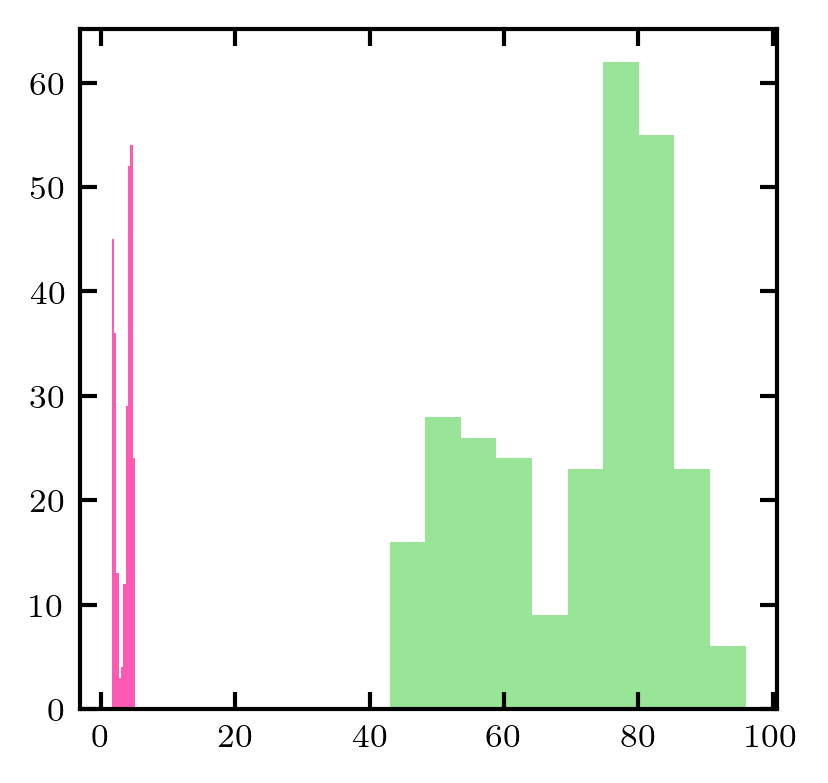

In [48]:
# Read in the data
index, eruptions, waiting = np.loadtxt('old_faithful.txt', skiprows = 1, unpack = True)

#Inspect
# Inspect
plt.hist(eruptions, color = 'deeppink', alpha = 0.7, label = 'Raw Eruption Data')
plt.hist(waiting, color = 'limegreen', alpha = 0.5, label = 'Raw Wait Time')

Now that we've read in the data, we'll scale it so that both parameters are distributed around zero with a standard varience. We can do this by applying the transformation

$$ y_{i}^{(j)} = \frac{x_{i}^{(j)} - \mu^{(j)}}{\sigma^{(j)}}$$

In [41]:
# Scale the data
def scale(data1): 
    return (data1 - np.mean(data1)) / np.std(data1)

waiting_scaled = scale(waiting)
eruptions_scaled = scale(eruptions)

# Inspect scaled means and variences
print('Mean of scaled eruptions: ' + str(np.mean(eruptions_scaled)))
print('Mean of scaled Wait Time: ' + str(np.mean(waiting_scaled)))

print('Standard Deviation of scaled eruptions: ' + str(np.std(eruptions_scaled)))
print('Standard Deviation of scaled Wait Time: ' + str(np.std(waiting_scaled)))

Mean of scaled eruptions: 4.800081900585235e-16
Mean of scaled Wait Time: 4.408238480129298e-16
Standard Deviation of scaled eruptions: 1.0
Standard Deviation of scaled Wait Time: 1.0


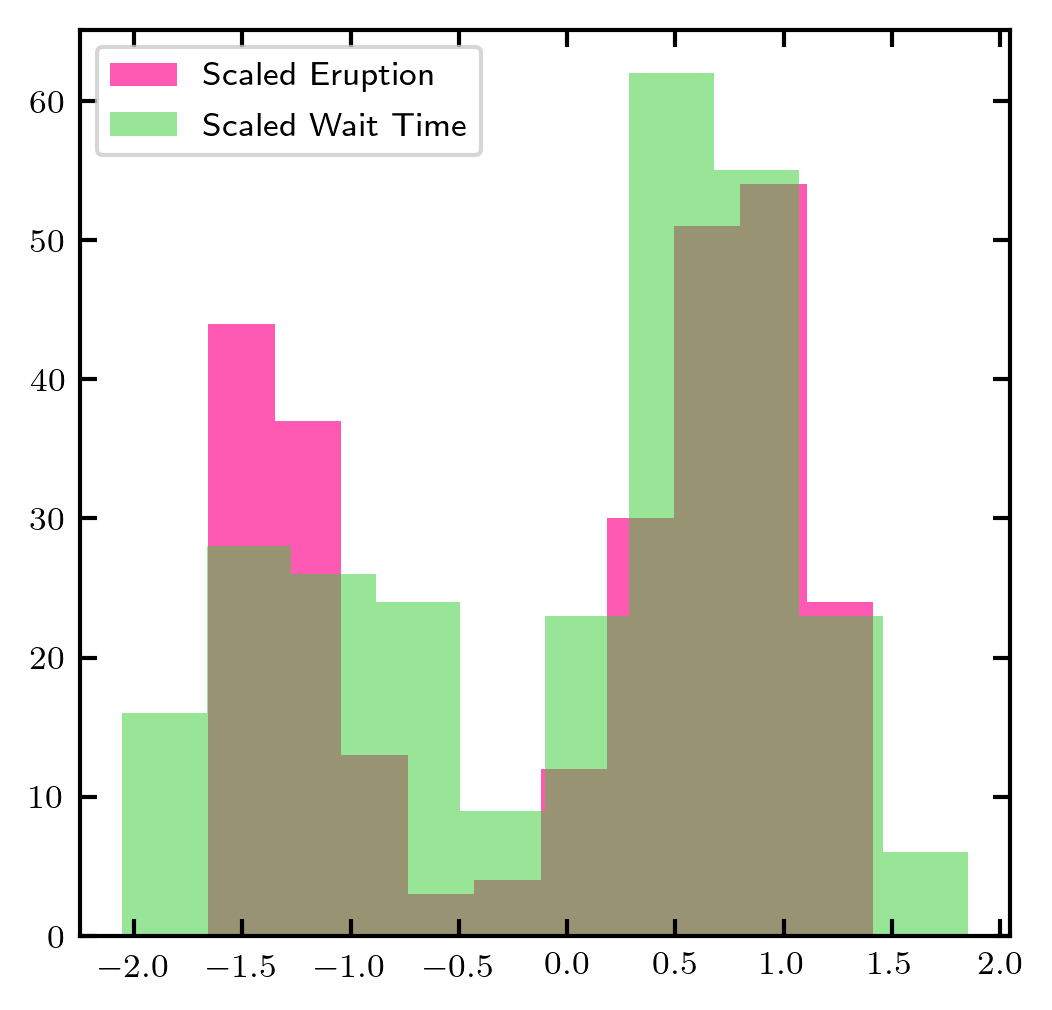

In [49]:
# Inspect graphically
plt.figure(figsize = [4,4])
plt.hist(eruptions_scaled, color = 'deeppink', alpha = 0.7, label = 'Scaled Eruption')
plt.hist(waiting_scaled, color = 'limegreen', alpha = 0.5, label = 'Scaled Wait Time')
plt.legend(fontsize = 8)


Our data has been transformed and is ready for further analysis.

______

### Part B

Use `sklearn.cluster.KMeans` to split the Old Faithful data into 2 clusters.  Plot the data with each point colored according to its cluster label.  Also plot the centers of the clusters, and make them distuinguishable from the data.

Read more at http://scikit-learn.org/stable/modules/density.html.  Consider looking at the examples on the `scikit-learn` website and the lecture.

____________

### $\textit{Answer:}$

Like above, we'll start by taking a look at the data. This time we'll plot the two scaled parameters against each other in a scatter plot:


Text(0, 0.5, 'Scaled Number of Eruptions')

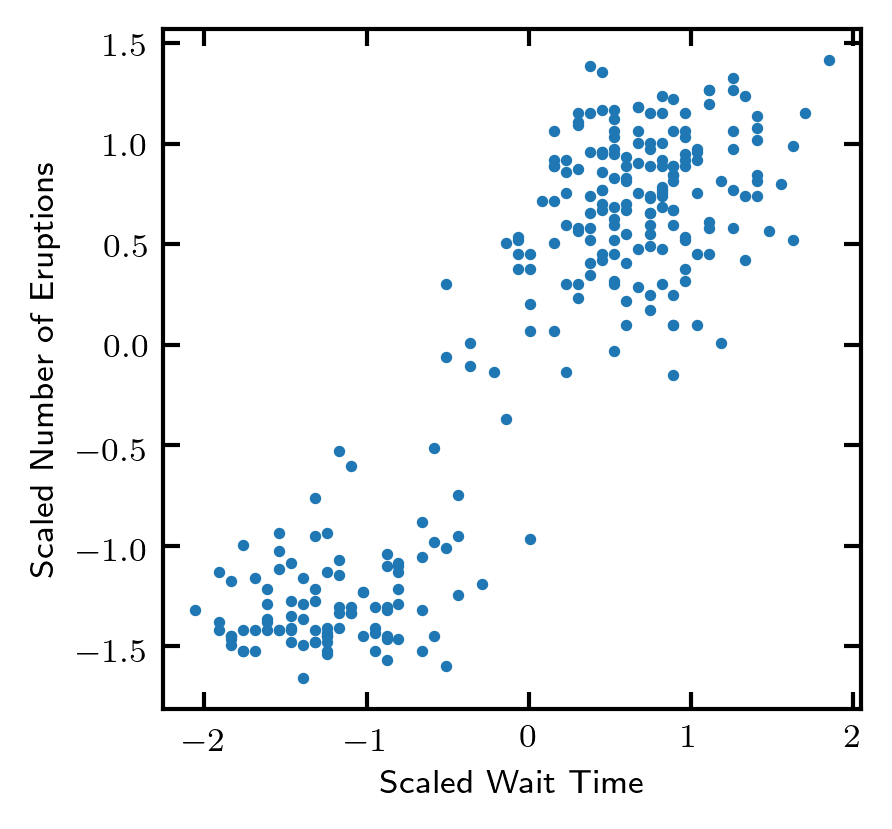

In [52]:
plt.figure(figsize = [3,3],dpi = 300)

plt.scatter(waiting_scaled,eruptions_scaled, s = 3)
plt.xlabel("Scaled Wait Time")
plt.ylabel("Scaled Number of Eruptions")

Our next task is to run a k-means cluster analysis. We see from the above scatter plot that there are probably two clusters of data: one in the lower left of parameter space and the other in the upper right.

In [70]:
# Run k-means algorathim from sklean: 
#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

from sklearn.cluster import KMeans

# Reformat data to be compatible with sklearn method:
temp=np.vstack((waiting_scaled, eruptions_scaled))
X = temp.T

# Run analysis
km = KMeans(n_clusters=2)
y_km = km.fit_predict(X)

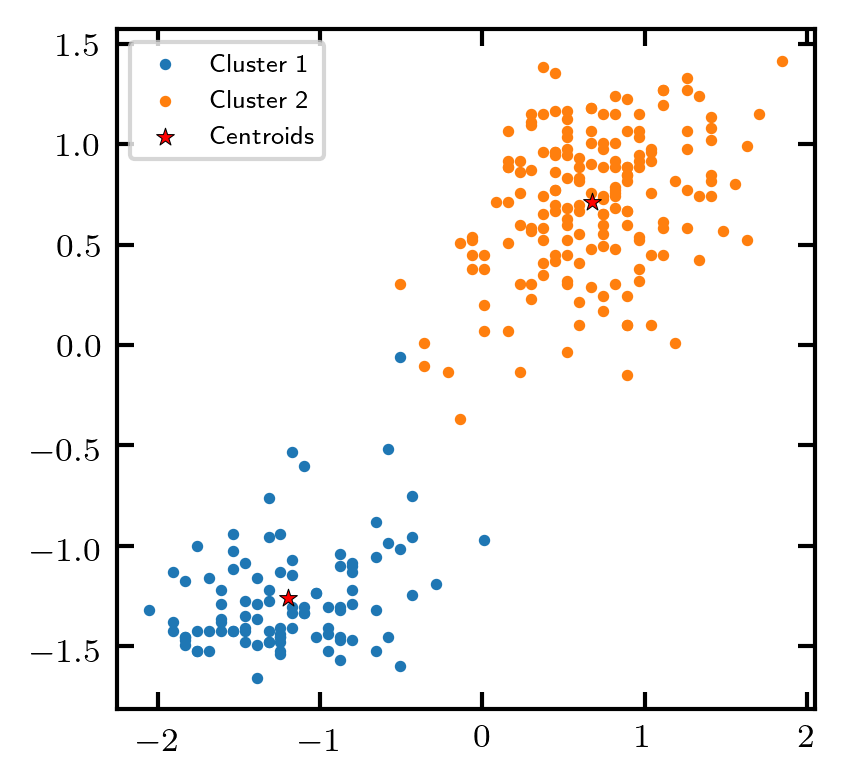

In [88]:
# Plot
plt.figure(dpi = 300)
plt.scatter(X[y_km == 0,0], X[y_km == 0,1], s = 3, label = 'Cluster 1')
plt.scatter(X[y_km == 1,0], X[y_km == 1,1], s = 3, label = 'Cluster 2')
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s= 20, marker='*',c='red', edgecolor = 'black', linewidth = 0.25,label='Centroids')
plt.legend(fontsize = 6)

### Part C

Code from scratch (that is, with default python and numpy only) your own k-means clustering algorithm to split the Old Faithful data into 2 clusters.  Refer to the lecture and a section from the Bishop textbook on canvas titled *Bishop9-1.pdf*.  Figure 9.1 in the text is particularly informative.

### $\textit{Answer:}$

The K-means algorithm sounds straightforward enough: We assign two (in this case) random centroid locations, evaluate the Euclidean distance from each point to that centroid, then assign each point to the closer of the two centroids.

From here we simply take the mean coordinates of the newly formed clusters and make those the new centroids. We can repeat the distance measruement, cluster classification, and centroid placement iteratively until our cluster membership has converged.

We'll start by making some functions that will be useful:

In [218]:
# Reformat the data
data = np.vstack((waiting_scaled, eruptions_scaled)).T
print(data.shape)
print(data)



(272, 2)
[[ 0.59712344  0.09849886]
 [-1.24518118 -1.48145856]
 [ 0.22866251 -0.13586149]
 [-0.6556437  -1.05750332]
 [ 1.03927655  0.91744345]
 [-1.171489   -0.53085085]
 [ 1.2603531   1.06402839]
 [ 1.03927655  0.09849886]
 [-1.46625773 -1.34979544]
 [ 1.03927655  0.75681445]
 [-1.24518118 -1.45249268]
 [ 0.96558436  0.37674691]
 [ 0.52343125  0.62515133]
 [-1.76102647 -1.52534627]
 [ 0.89189218  1.06402839]
 [-1.39256555 -1.1593228 ]
 [-0.6556437  -1.52534627]
 [ 0.96558436  1.1518038 ]
 [-1.39256555 -1.65700939]
 [ 0.59712344  0.66903904]
 [-1.46625773 -1.48145856]
 [-1.76102647 -1.52534627]
 [ 0.52343125 -0.03316426]
 [-0.13979841 -0.36934409]
 [ 0.22866251  0.91744345]
 [ 0.89189218  0.09849886]
 [-1.171489   -1.33487362]
 [ 0.37604688  0.5224541 ]
 [ 0.52343125  0.31793739]
 [ 0.59712344  0.82966804]
 [ 0.15497033  0.71292674]
 [ 0.44973907  0.85951168]
 [-0.36087496 -0.10601785]
 [ 0.67081562  0.47856639]
 [ 0.22866251  0.30301557]
 [-1.39256555 -1.29098592]
 [-1.68733429 -1.42

In [219]:
# Find distance between points
def euclid(x1,x2):
    return np.sqrt((x1[0]-x2[0])**2 + (x1[1] - x2[1])**2)

# Test
print(euclid(data[0],data[1]))


2.4270046862838006


Text(0, 0.5, 'Scaled Number of Eruptions')

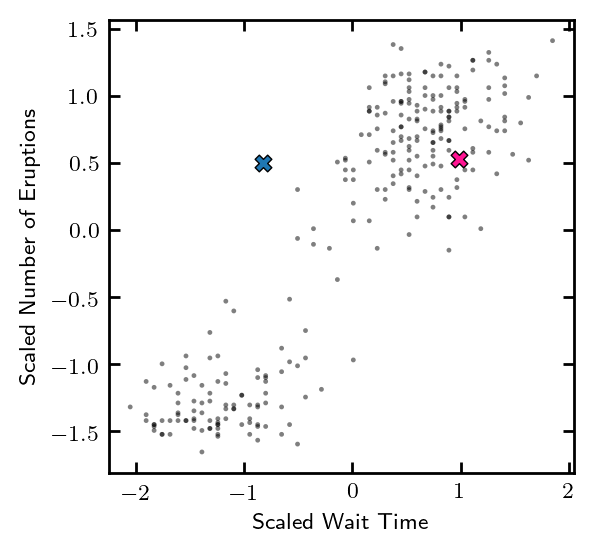

In [220]:
# Create centroid list
num_centroids = 2


# Starting points
cent_1 = np.random.uniform(low = np.min(data, axis = 0), high = np.max(data,axis = 0), size = num_centroids)
cent_2 = np.random.uniform(low = np.min(data, axis = 0), high = np.max(data,axis = 0), size = num_centroids)
centroids = np.vstack((cent_1, cent_2)).T


# Inspect
plt.figure(figsize = [3,3],dpi = 200)

plt.scatter(waiting_scaled,eruptions_scaled, s = 3, color = 'black', alpha = 0.5, edgecolor = 'none')
# Centroids
plt.scatter(centroids[0][0],centroids[1][0], marker = 'X', linewidth = 0.5, edgecolor = 'black')
plt.scatter(centroids[0][1],centroids[1][1], marker = 'X', linewidth = 0.5, color = 'deeppink', edgecolor = 'black')
plt.xlabel("Scaled Wait Time")
plt.ylabel("Scaled Number of Eruptions")


Next, we want to evalute the distance from each point in the data to the centroids. We'll assign each point to the closer cluster:

In [221]:
# Null arrays to be populated
dist_1 = np.zeros(len(data))
dist_2 = np.zeros(len(data))
membership = np.zeros(len(data))

for i in range(0,len(data)):
    dist_1[i] = euclid(cent_1,data[i])
    dist_2[i] = euclid(cent_2, data[i])
    
    if dist_1[i] < dist_2[i]:
        membership[i] = 1
    else:
        membership[i] = 2
    



    
    

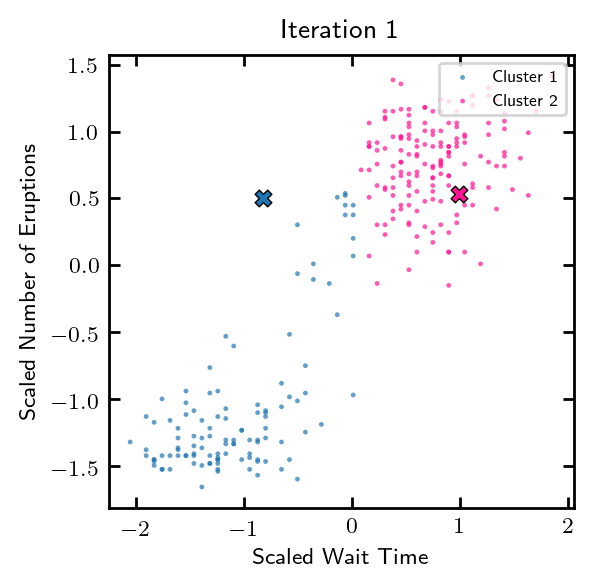

In [222]:
# Inspect
cluster_1 = np.where(membership == 1)
cluster_2 = np.where(membership == 2)

plt.figure(figsize = [3,3],dpi = 200)

# Memberhip
plt.scatter(waiting_scaled[cluster_1],eruptions_scaled[cluster_1], s=3, alpha = 0.7, color ='tab:blue', edgecolor = 'none', label = 'Cluster 1')
plt.scatter(waiting_scaled[cluster_2],eruptions_scaled[cluster_2],s=3, alpha = 0.7,  color ='deeppink', edgecolor = 'none', label = 'Cluster 2')

# Centroids
plt.scatter(centroids[0][0],centroids[1][0], marker = 'X', linewidth = 0.5, edgecolor = 'black')
plt.scatter(centroids[0][1],centroids[1][1], marker = 'X', linewidth = 0.5, color = 'deeppink', edgecolor = 'black')
plt.title('Iteration 1')
plt.xlabel("Scaled Wait Time")
plt.ylabel("Scaled Number of Eruptions")
plt.legend(fontsize = 6, loc = 'upper right')


We now have the data split into two clusters based off the intial centroid positions. Next we'll move the centroids to the mean coordinate of each cluster:

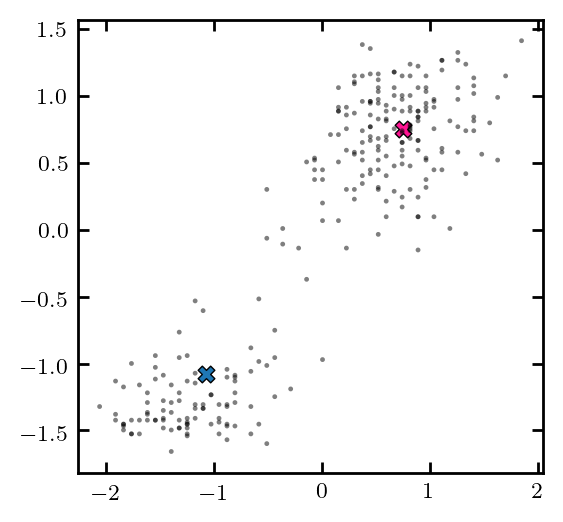

In [223]:
cent_1 = (np.mean(waiting_scaled[cluster_1]),np.mean(eruptions_scaled[cluster_1]))
cent_2 = (np.mean(waiting_scaled[cluster_2]),np.mean(eruptions_scaled[cluster_2]))
centroids = np.vstack((cent_1, cent_2)).T

# Inspect 
plt.figure(figsize = [3,3],dpi = 200)
# Centroids
plt.scatter(centroids[0][0],centroids[1][0], marker = 'X', linewidth = 0.5, edgecolor = 'black')
plt.scatter(centroids[0][1],centroids[1][1], marker = 'X', linewidth = 0.5, color = 'deeppink', edgecolor = 'black')
plt.scatter(waiting_scaled,eruptions_scaled, s = 3, color = 'black', alpha = 0.5, edgecolor = 'none')

Now we can repeat the above classification based off distances to the new centroid:


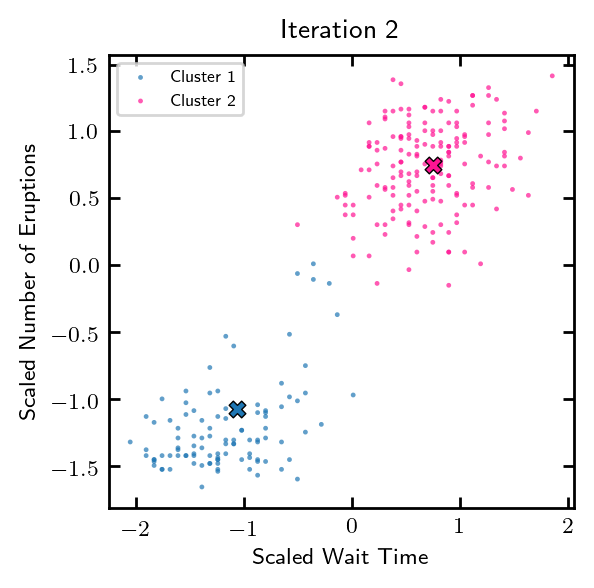

In [224]:
for i in range(0,len(data)):
    dist_1[i] = euclid(cent_1,data[i])
    dist_2[i] = euclid(cent_2, data[i])
    
    if dist_1[i] < dist_2[i]:
        membership[i] = 1
    else:
        membership[i] = 2

cluster_1 = np.where(membership == 1)
cluster_2 = np.where(membership == 2)

plt.figure(figsize = [3,3],dpi = 200)

# Memberhip
plt.scatter(waiting_scaled[cluster_1],eruptions_scaled[cluster_1], s=3, alpha = 0.7, color ='tab:blue', edgecolor = 'none', label = 'Cluster 1')
plt.scatter(waiting_scaled[cluster_2],eruptions_scaled[cluster_2],s=3, alpha = 0.7,  color ='deeppink', edgecolor = 'none', label = 'Cluster 2')

# Centroids
plt.scatter(centroids[0][0],centroids[1][0], marker = 'X', linewidth = 0.5, edgecolor = 'black')
plt.scatter(centroids[0][1],centroids[1][1], marker = 'X', linewidth = 0.5, color = 'deeppink', edgecolor = 'black')

plt.title('Iteration 2')
plt.xlabel("Scaled Wait Time")
plt.ylabel("Scaled Number of Eruptions")
plt.legend(fontsize = 6, loc = 'upper left')


Now we're getting there. We can continue this process until our cluster membership settles in:

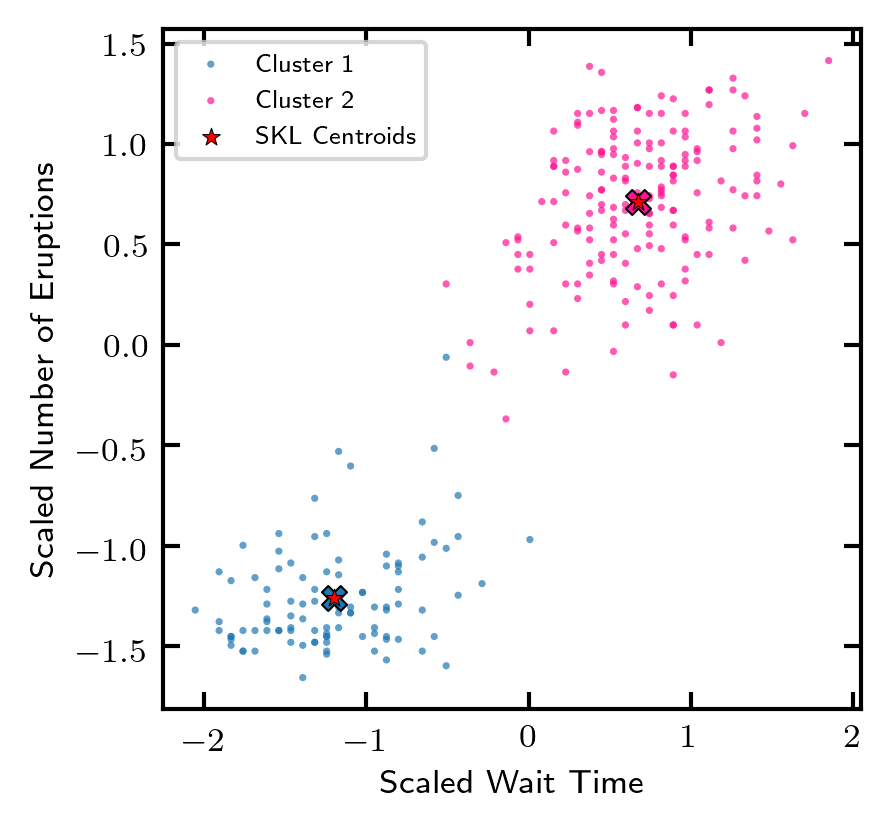

In [230]:
max_iter = 15

for j in range(0,max_iter):
    # Find new centroid positions
    cent_1 = (np.mean(waiting_scaled[cluster_1]),np.mean(eruptions_scaled[cluster_1]))
    cent_2 = (np.mean(waiting_scaled[cluster_2]),np.mean(eruptions_scaled[cluster_2]))
    centroids = np.vstack((cent_1, cent_2)).T
    
    # Determine cluster membership
    for i in range(0,len(data)):
        dist_1[i] = euclid(cent_1,data[i])
        dist_2[i] = euclid(cent_2, data[i])
    
        if dist_1[i] < dist_2[i]:
            membership[i] = 1
        else:
            membership[i] = 2
    
    cluster_1 = np.where(membership == 1)
    cluster_2 = np.where(membership == 2)

  
    
plt.figure(dpi = 300)

# Memberhip
plt.scatter(waiting_scaled[cluster_1],eruptions_scaled[cluster_1], s=3, alpha = 0.7, color ='tab:blue', edgecolor = 'none', label = 'Cluster 1')
plt.scatter(waiting_scaled[cluster_2],eruptions_scaled[cluster_2],s=3, alpha = 0.7,  color ='deeppink', edgecolor = 'none', label = 'Cluster 2')

# Centroids
plt.scatter(centroids[0][0],centroids[1][0], marker = 'X', linewidth = 0.5, edgecolor = 'black')
plt.scatter(centroids[0][1],centroids[1][1], marker = 'X', linewidth = 0.5, color = 'deeppink', edgecolor = 'black')

# Scikit-learn centroids for comparison 
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s= 20, marker='*',c='red', edgecolor = 'black', linewidth = 0.25,label='SKL Centroids')

plt.xlabel("Scaled Wait Time")
plt.ylabel("Scaled Number of Eruptions")
plt.legend(fontsize = 6, loc = 'upper left')
  
    

So after a few iterations we have two distinct cluster populations that closely (if not exactly) match the out-of-the-box implementation of K-Means from scikit-learn. Also plotted  in the above figure are the original centroids determined by the scikit-learn algorithm (red stars). These centroids also perfeclty match our hand built result.

_______________
________________


# Problem 2

### Part A

Load data from canvas titled `spins.txt`.  This is a set of classical spin configurations on a 2D square lattice sampled with Monte Carlo.  The first column contains the temperature at which the configuration was sampled.  The remaining 400 points (its a $20 \times 20$ lattice) correspond to the measured spin, either up or down, on particular lattice sites.  There are 10,000 data points in total.  It is not necessary to preprocess the data.

Perform PCA on the spin data.  Since PCA is an unsupervised machine learning method, by definition labels are not used to train the model.  Let's treat the temperature as labels, so train PCA solely on the spin part of the data.  You can do PCA through your method of choice (e.g. `sklearn`, diagonalizing the covariance yourself with `numpy`, etc.)

____

### $\textit{Answer:}$ 

In [342]:
# Read in the data
temps  = np.loadtxt('spins.txt', usecols = (0))
spins = np.loadtxt('spins.txt', usecols = np.arange(1,401))

In [346]:
# Inspect
print("Temp info:")
print(temps)
print("Length: " +str(len(temps)))
print("-------------------------------------------")
print("Spin info:")
print(spins)
print("Length: " +str(len(spins)))
print("Dimmensionality: " + str(np.shape(spins)))


Temp info:
[1.06345927 1.06345927 1.06345927 ... 3.53837063 3.53837063 3.53837063]
Length: 10000
-------------------------------------------
Spin info:
[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [ 1.  1.  1. ... -1. -1.  1.]
 [-1. -1. -1. ... -1.  1. -1.]
 [ 1. -1.  1. ... -1. -1.  1.]]
Length: 10000
Dimmensionality: (10000, 400)


We'll preform the PCA analysis following the prescription outilned in scikit-learn:

In [347]:
'''
Reminder about numpy ndarrays because i'm forgetful:
row vector: arr[n,:]
column vector: arr[:,n]
'''

print(np.shape(spins))

(10000, 400)


In [376]:
# Import package from sklearn
from sklearn.decomposition import PCA


X = spins
pca = PCA(n_components = 'mle', svd_solver = 'full')
pca.fit(X)


PCA(copy=True, iterated_power='auto', n_components='mle', random_state=None,
    svd_solver='full', tol=0.0, whiten=False)

### Part B

Plot the resulting fractional variance of the principal components.  Briefly describe what you see.

Inspect the relevant principal components.  If you plot the components, be mindful of the way `matplotlib` will automatically scale plots.  Discuss the components: how do you interpret them?

### $\textit{Answer}:$
The fraction of varience explained is containe din the `explained_variance_ratio_` method:

In [377]:
print(pca.explained_variance_ratio_.shape)
print(len(pca.components_))

(345,)
345


(-0.1, 10.1)

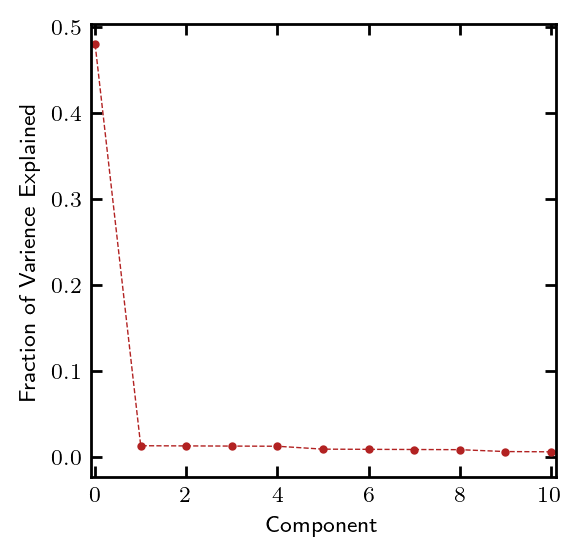

In [378]:
plt.figure(figsize = [3,3], dpi = 200)
plt.plot(np.arange(0,len(pca.components_)),pca.explained_variance_ratio_, linestyle = '--',
         linewidth = 0.5, color = 'firebrick', marker = 'o', markersize = 2)
plt.xlabel('Component')
plt.ylabel('Fraction of Varience Explained')
plt.xlim(-0.1,10.1)

In [411]:
print(pca.components_)
print(len(pca.components_[0]), )

[[-0.04998546 -0.05030088 -0.0498478  ... -0.05070266 -0.04989702
  -0.05013992]
 [-0.01956708  0.00217228  0.03013633 ... -0.08127032 -0.06676716
  -0.04030606]
 [-0.00214715  0.00324478 -0.00253266 ... -0.00613911  0.00374425
   0.01171291]
 ...
 [ 0.02267915 -0.0525407  -0.01188216 ... -0.05753308  0.07670945
  -0.00921415]
 [-0.04411795 -0.0388918   0.03123006 ... -0.11552119  0.10114877
  -0.06904614]
 [ 0.07657513  0.00828936 -0.06003228 ...  0.02089063 -0.02926838
   0.08725562]]
400


(-0.1, 0.1)

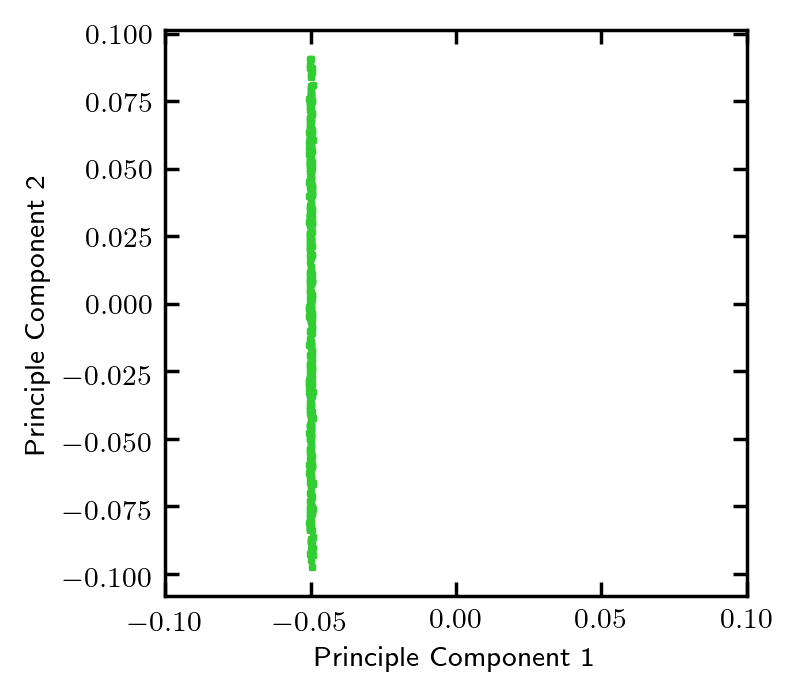

In [384]:
# Inspect components
comp1 = pca.components_[0]
comp2 = pca.components_[1]

plt.figure(figsize = [3,3], dpi = 250)
plt.scatter(comp1,comp2, marker = 's', s = 2, color = 'limegreen')

plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')

plt.xlim(-0.1,0.1)


We see that our principle components are now along a plane (which is what we expect them to do in PCA). 

### Part C

Plot the data in terms of the 1st and 2nd principal components.  Remember the temperatures we ignored during PCA?  When you plot this data, color every point based on the temperature in which it was sampled.  You can call `matplotlib.pyplot.colorbar` to automatically draw a color legend.  Briefly describe what you see.

### $ \textit{Answer:}$

In [387]:
# Transform
eigvecs = pca.fit_transform(X)

In [413]:
print(eigvecs.shape)
print(eigvecs)

(10000, 345)
[[ 2.14374239e+01 -3.80848610e-03  1.71779921e-03 ... -5.22045109e-03
  -1.11644580e-02 -4.06404609e-03]
 [ 2.14374239e+01 -3.80848610e-03  1.71779921e-03 ... -5.22045109e-03
  -1.11644580e-02 -4.06404609e-03]
 [ 2.14374239e+01 -3.80848610e-03  1.71779921e-03 ... -5.22045109e-03
  -1.11644580e-02 -4.06404609e-03]
 ...
 [-1.76439566e+00  2.01246658e+00 -2.79297118e+00 ... -2.45336217e-01
   4.75709779e-01  2.65218470e+00]
 [ 3.54255045e+00  6.67563697e-01 -1.79817194e+00 ... -1.23581590e-01
   9.17124364e-01  3.08572669e-01]
 [ 4.22488788e+00  1.89089711e+00  2.29952477e+00 ...  2.20507887e-02
  -7.19472298e-01 -9.32502446e-01]]


In [426]:
len(eigvecs[:,1])

10000

(10000, 345)


Text(0, 0.5, 'Eigenvector 2')

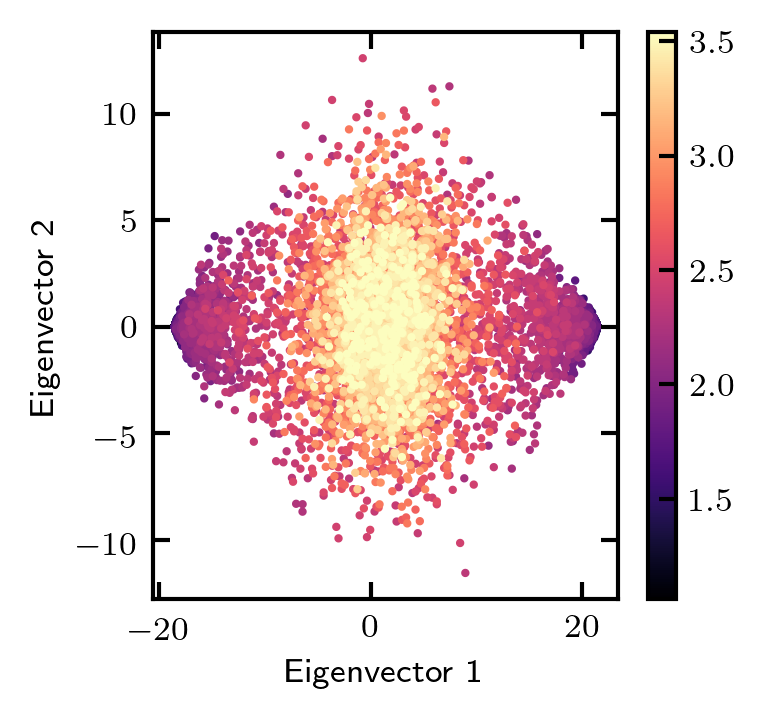

In [433]:
print(eigvecs.shape)
plt.figure(figsize = [2.5,2.5], dpi = 300)
plt.scatter(eigvecs[:,0],eigvecs[:,1], s = 1, c = temps, cmap = 'magma')
plt.colorbar()

plt.xlabel('Eigenvector 1')
plt.ylabel('Eigenvector 2')


Text(0.5, 0, 'Eigenvector 3')

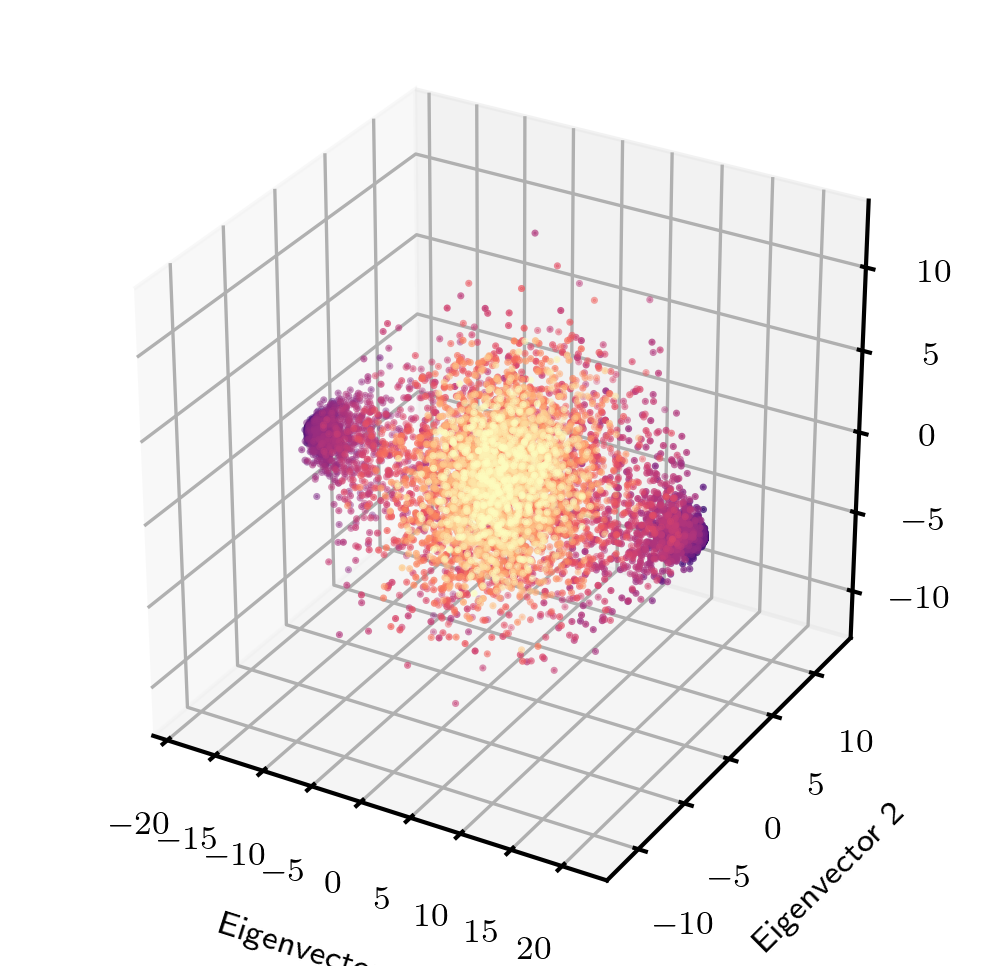

In [454]:
# Try making a 3d scatter plot of first 3 eigenvecs
from mpl_toolkits.mplot3d import axes3d, Axes3D
# data
x = eigvecs[:,0]
y = eigvecs[:,1]
z = eigvecs[:,2]

# Creating figure
fig = plt.figure(figsize = (4, 4))
ax = plt.axes(projection ="3d")
 
# Creating plot


ax.scatter3D(x, y, z, c = temps, cmap = 'magma', s = 0.5)
ax.set_xlabel('Eigenvector 1')
ax.set_ylabel('Eigenvector 2')
ax.set_zlabel('Eigenvector 3')

 


### Part D

Lastly, discuss your trained model and its physical ramifications.  Specifically address these points:

- What does the 1st principal component correspond to, physically?

- In the context of PCA, what effect does temperature have on the data?  Is this a gradual change of the data, or a sudden change?

- Why do you see 3 clusters in the transformed data?  I could also ask, why DON'T you see only 2?

### $\textit{Answer:}$

In the above 3d graph, we see that there are 3 clusters along the Eigenvector 1 axis. We can also see that two of the clusters are on opposite sides of the origin and all have colors associated with lower temperature measurements.

For this reason, I believe the 1st principle component corresponds to information regarding the spin of the electrons in the lattice sites. At low temperatures, we would expect the spins to be ordered either spin up or spin down. Statistical mechanics tells us that these spins should become randomized at high T - perhaps this is the cluster near the origin. 

Just as a sanity check, we can plot the 1st Principle component against the temperature to see see if it matches this behavior:

Text(0, 0.5, 'Eigenvector 1')

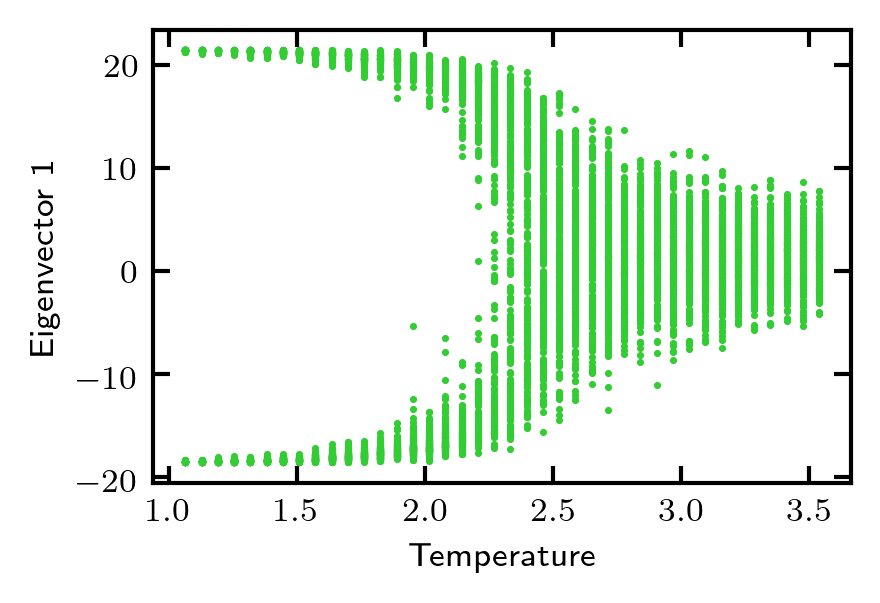

In [452]:
plt.figure(figsize = [3,2])
plt.scatter(temps, x,s = 0.5, c = 'limegreen')
plt.xlabel('Temperature')
plt.ylabel('Eigenvector 1')

Indeed, we see that the first Eigenvector takes one of two values at lower temperatures before converging to a blob beyond a critical point.

I'd say in the context of PCA, the effect of Temperature on the data is sudden. This is most visible in the above eigenvector plots. The temperature data doesn't just gradually change as you move across any of the three Eigenvector axes; it suddenly increases between the two clusters at either end of the Eigenvector 1 axis.

The answer as to why we see three clusters instead of only two clusters is realted to the physical interpretation of the first eigenvector being related to spin. When the spin information is scrambled by the high temperatures, we end up with a third cluster along the Eigenvector 1 axis.